In [1]:
import torch
import torchvision
from torchvision import datasets,transforms, models
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable 
import time
%matplotlib inline
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import torch.nn as nn

In [2]:
df = pd.read_csv('mci_.csv')
df

,id,age,gender,convert,agegap
0,023_S_1046,71.6,0,0,[1.8606339]
1,016_S_1138,67.4,0,1,[7.0517807]
2,023_S_0030,80.0,1,1,[1.7800751]
3,023_S_0376,70.5,0,0,[2.7118073]
4,011_S_0362,70.5,1,1,[5.1724854]
...,...,...,...,...,...
195,023_S_0030,80.0,1,1,[-6.016083]
196,016_S_1117,68.9,1,1,[5.4196396]
197,011_S_0861,87.1,0,1,[-15.182182]
198,023_S_1046,71.6,0,0,[2.6811981]


In [3]:
transform = transforms.Compose([transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])

In [4]:
# ADNI_002_S_0559_MR_MPR____N3__Scaled_2_Br_20081001115336170_S15922_I118679
class MyDataset(Dataset):
    def __init__(self, path, df, transform=transform):
        self.transform = transform
        self.images = os.listdir(path)
        self.labels = df
        self.path = path
 
    def __len__(self):
        return len(self.images)
 
    def __getitem__(self, index):
        img = cv2.imread(os.path.join(self.path,self.images[index]))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img2 = np.zeros_like(img)
        img2[:,:,0] = gray
        img2[:,:,1] = gray
        img2[:,:,2] = gray
        cv2.imwrite('./mci_rgb/'+self.images[index], img2)
        img = Image.open('./mci_rgb/'+self.images[index])
#         img = self.images[index, :, :, :]
#         img = img/1.0
#         img = torch.from_numpy(img).float()
#         label = self.labels[index]
        df_ = self.labels
        pid = self.images[index]
        sex = df_.loc[df_['id']== pid[0:10]]['gender'].reset_index()
        sex = sex['gender'][0]     
        conversion = df_.loc[df_['id']== pid[0:10]]['convert'].reset_index()
        label = conversion['convert'][0]
        agegap = df_.loc[df_['id']== pid[0:10]]['agegap'].reset_index()
        agegap = agegap['agegap'][0]

        sample = {'image': img, 'label': label, 'sex': sex, 'agegap': agegap}
        if self.transform:
            sample['image'] = self.transform(sample['image'])
        return sample

In [5]:
path = './mci_jpg'
dataset = MyDataset(path=path,df=df)

In [6]:
print(len(dataset))
print(dataset[0]['image'].shape)

200
torch.Size([3, 224, 224])


In [7]:
print(type(dataset[0]['label']))
print(dataset[0]['label'])

<class 'numpy.int64'>
0


In [8]:
from sklearn.model_selection import train_test_split
trainset,testset=train_test_split(dataset,test_size=0.2)

In [9]:
train_loader = DataLoader(trainset, batch_size=1, shuffle=True)
test_loader = DataLoader(testset, batch_size=1, shuffle=True)


In [10]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

False


In [11]:
model = models.vgg19(pretrained = True)
print(model)

/Users/ciya/miniforge3/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ciya/miniforge3/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [110]:
for parma in model.parameters():
    parma.requires_grad = False

model.classifier = torch.nn.Sequential(torch.nn.Linear(25088, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=0.5),
                                       torch.nn.Linear(4096, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=0.5),
                                       torch.nn.Linear(4096, 2))
                                      

for index, parma in enumerate(model.classifier.parameters()):
    if index == 4 | 5 | 6:
        parma.requires_grad = True
    
if use_gpu:
    model = model.cuda()


learning_rate = 0.001
num_epochs = 50
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [111]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [112]:
from sklearn.metrics import mean_squared_error,r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F

In [113]:
#cross-validation
def get_kfold_data(k, i, X, y):  
     
    fold_size = X.shape[0] // k  
    
    val_start = i * fold_size
    if i != k - 1:
        val_end = (i + 1) * fold_size
        X_valid, y_valid = X[val_start:val_end], y[val_start:val_end]
        X_train = torch.cat((X[0:val_start], X[val_end:]), dim = 0)
        y_train = torch.cat((y[0:val_start], y[val_end:]), dim = 0)
    else: 
        X_valid, y_valid = X[val_start:], y[val_start:] 
        X_train = X[0:val_start]
        y_train = y[0:val_start]
        
    return X_train, y_train, X_valid,y_valid

def train(model, data_loader, optimizer, criterion):
    model.train = True
    total_loss, total_acc = 0, 0
#     y_true, y_pred = [], []
#     for step, data in enumerate(tqdm(data_loader)):
#             batch_x, batch_y = data['image'],data['label']
#             batch_x, batch_y = Variable(batch_x), Variable(batch_y)
#             batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # GPU
#             out = model(batch_x)
#             loss = criterion(out, batch_y)
#             total_loss += loss.item()
#             # pred is the expect class
#             # batch_y is the true label
#             pred = torch.max(out, 1)[1]
#             total_correct = (pred == batch_y).sum()
#             total_acc += total_correct.item()
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#     return total_loss/len(data_loader), total_acc/len(data_loader)
            
    for step, batch in enumerate(tqdm(data_loader)):
#         batch = batch.to(device)
        optimizer.zero_grad()
        outputs = model(batch['image'].to(device))
        batch['label'] = batch['label'].to(device)
        loss = criterion(outputs, batch['label'])
#         loss.requires_grad_(True)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = torch.max(outputs, 1)[1]
        total_correct = (pred == batch['label']).sum()
        total_acc += total_correct.item() 

    return total_loss / len(data_loader), total_acc/len(data_loader)


def evaluate(model, data_loader, criterion):
    model.train = False
    total_loss, total_acc = 0, 0
#     y_true, y_pred = [], []
    with torch.no_grad():
#         for step, data in enumerate(tqdm(data_loader)):
#             batch_x, batch_y = data['image'],data['label']
#             batch_x, batch_y = Variable(batch_x), Variable(batch_y)
#             batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # GPU
#             out = model(batch_x)
#             loss = criterion(out, batch_y)
#             total_loss += loss.item()
#             # pred is the expect class
#             # batch_y is the true label
#             pred = torch.max(out, 1)[1]
#             total_correct = (pred == batch_y).sum()
#             total_acc += total_correct.item()

#     return total_loss/len(data_loader), total_acc/len(data_loader)

         for step, batch in enumerate(tqdm(data_loader)):
#             batch = batch.to(device)
            outputs = model(batch['image'].to(device))
            batch['label'] = batch['label'].to(device)
            loss = criterion(outputs, batch['label'])
            total_loss += loss.item()
            pred = torch.max(outputs, 1)[1]
            total_correct = (pred == batch['label']).sum()
            total_acc += total_correct.item() 
#             y_true.extend(batch['label'].tolist())          
#             y_pred.extend(outputs.tolist())
#     mse = mean_squared_error(y_true, y_pred)
#     r2 = r2_score(y_true,y_pred)
    return total_loss / len(data_loader), total_acc/len(data_loader)

In [114]:
# train
loss_train, loss_test=[],[]
acc_train, acc_test=[],[]
min_loss = 1000

for epoch in range(num_epochs):

    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    
    loss_train.append(train_loss)
    loss_test.append(test_loss)
    acc_train.append(train_acc)
    acc_test.append(test_acc)
    
    if test_loss < min_loss:
        min_loss = test_loss
        torch.save(model.state_dict(), './best_model_mci_predction.pt')


    print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    print(f"Epoch {epoch + 1}/{num_epochs}: Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
    

100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.42it/s]


Epoch 1/50: Train Loss: 25.5576, Test Loss: 18.2599
Epoch 1/50: Train Acc: 0.4938, Test Acc: 0.6250


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  8.96it/s]


Epoch 2/50: Train Loss: 20.7281, Test Loss: 13.4274
Epoch 2/50: Train Acc: 0.6625, Test Acc: 0.6000


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.11it/s]


Epoch 3/50: Train Loss: 14.3181, Test Loss: 44.1577
Epoch 3/50: Train Acc: 0.7188, Test Acc: 0.4750


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.52it/s]


Epoch 4/50: Train Loss: 12.4537, Test Loss: 26.5153
Epoch 4/50: Train Acc: 0.7688, Test Acc: 0.6000


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  8.85it/s]


Epoch 5/50: Train Loss: 10.1541, Test Loss: 15.6338
Epoch 5/50: Train Acc: 0.8063, Test Acc: 0.6750


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.18it/s]


Epoch 6/50: Train Loss: 8.8109, Test Loss: 21.1003
Epoch 6/50: Train Acc: 0.8125, Test Acc: 0.6500


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.59it/s]


Epoch 7/50: Train Loss: 5.2209, Test Loss: 18.6633
Epoch 7/50: Train Acc: 0.8375, Test Acc: 0.6250


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.59it/s]


Epoch 8/50: Train Loss: 2.3188, Test Loss: 15.8351
Epoch 8/50: Train Acc: 0.9062, Test Acc: 0.6750


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.59it/s]


Epoch 9/50: Train Loss: 1.6640, Test Loss: 8.9493
Epoch 9/50: Train Acc: 0.9375, Test Acc: 0.7250


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.63it/s]


Epoch 10/50: Train Loss: 1.5012, Test Loss: 9.8614
Epoch 10/50: Train Acc: 0.9375, Test Acc: 0.7000


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.40it/s]


Epoch 11/50: Train Loss: 1.5591, Test Loss: 4.5780
Epoch 11/50: Train Acc: 0.9375, Test Acc: 0.7500


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.61it/s]


Epoch 12/50: Train Loss: 0.9486, Test Loss: 9.8853
Epoch 12/50: Train Acc: 0.9187, Test Acc: 0.6500


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.63it/s]


Epoch 13/50: Train Loss: 5.6155, Test Loss: 73.6776
Epoch 13/50: Train Acc: 0.8938, Test Acc: 0.6500


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.51it/s]


Epoch 14/50: Train Loss: 7.9197, Test Loss: 47.9635
Epoch 14/50: Train Acc: 0.8875, Test Acc: 0.6000


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.65it/s]


Epoch 15/50: Train Loss: 18.5567, Test Loss: 79.2267
Epoch 15/50: Train Acc: 0.8250, Test Acc: 0.5750


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.05it/s]


Epoch 16/50: Train Loss: 7.1357, Test Loss: 32.5393
Epoch 16/50: Train Acc: 0.9187, Test Acc: 0.7000


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.60it/s]


Epoch 17/50: Train Loss: 2.3644, Test Loss: 23.3436
Epoch 17/50: Train Acc: 0.9500, Test Acc: 0.7000


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.59it/s]


Epoch 18/50: Train Loss: 1.3469, Test Loss: 60.4846
Epoch 18/50: Train Acc: 0.9688, Test Acc: 0.6250


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.57it/s]


Epoch 19/50: Train Loss: 6.1917, Test Loss: 55.3210
Epoch 19/50: Train Acc: 0.9125, Test Acc: 0.5750


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.58it/s]


Epoch 20/50: Train Loss: 3.6619, Test Loss: 26.7758
Epoch 20/50: Train Acc: 0.9375, Test Acc: 0.6500


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.61it/s]


Epoch 21/50: Train Loss: 3.6047, Test Loss: 42.4069
Epoch 21/50: Train Acc: 0.9437, Test Acc: 0.7250


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.59it/s]


Epoch 22/50: Train Loss: 1.3310, Test Loss: 16.6970
Epoch 22/50: Train Acc: 0.9875, Test Acc: 0.6750


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.60it/s]


Epoch 23/50: Train Loss: 0.5362, Test Loss: 22.2323
Epoch 23/50: Train Acc: 0.9812, Test Acc: 0.7250


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.55it/s]


Epoch 24/50: Train Loss: 3.4854, Test Loss: 87.8551
Epoch 24/50: Train Acc: 0.9375, Test Acc: 0.7000


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.50it/s]


Epoch 25/50: Train Loss: 4.5184, Test Loss: 22.3320
Epoch 25/50: Train Acc: 0.9688, Test Acc: 0.7000


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.54it/s]


Epoch 26/50: Train Loss: 5.9762, Test Loss: 53.4076
Epoch 26/50: Train Acc: 0.9500, Test Acc: 0.6500


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.52it/s]


Epoch 27/50: Train Loss: 5.0507, Test Loss: 59.4814
Epoch 27/50: Train Acc: 0.9375, Test Acc: 0.7500


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.58it/s]


Epoch 28/50: Train Loss: 8.5488, Test Loss: 38.2965
Epoch 28/50: Train Acc: 0.9437, Test Acc: 0.7250


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.50it/s]


Epoch 29/50: Train Loss: 2.1559, Test Loss: 45.3703
Epoch 29/50: Train Acc: 0.9625, Test Acc: 0.7500


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.56it/s]


Epoch 30/50: Train Loss: 14.0204, Test Loss: 100.6900
Epoch 30/50: Train Acc: 0.9062, Test Acc: 0.5750


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.51it/s]


Epoch 31/50: Train Loss: 2.6409, Test Loss: 88.3936
Epoch 31/50: Train Acc: 0.9688, Test Acc: 0.5500


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.53it/s]


Epoch 32/50: Train Loss: 6.8237, Test Loss: 105.9855
Epoch 32/50: Train Acc: 0.9500, Test Acc: 0.7500


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.50it/s]


Epoch 33/50: Train Loss: 5.3033, Test Loss: 171.6353
Epoch 33/50: Train Acc: 0.9563, Test Acc: 0.6750


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.42it/s]


Epoch 34/50: Train Loss: 2.9039, Test Loss: 193.6252
Epoch 34/50: Train Acc: 0.9563, Test Acc: 0.6000


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.54it/s]


Epoch 35/50: Train Loss: 14.3717, Test Loss: 200.4737
Epoch 35/50: Train Acc: 0.9437, Test Acc: 0.6250


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.54it/s]


Epoch 36/50: Train Loss: 24.2262, Test Loss: 223.1600
Epoch 36/50: Train Acc: 0.9125, Test Acc: 0.6500


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.50it/s]


Epoch 37/50: Train Loss: 25.0410, Test Loss: 148.1928
Epoch 37/50: Train Acc: 0.9125, Test Acc: 0.6750


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.54it/s]


Epoch 38/50: Train Loss: 4.3945, Test Loss: 529.4424
Epoch 38/50: Train Acc: 0.9375, Test Acc: 0.7000


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.53it/s]


Epoch 39/50: Train Loss: 13.0518, Test Loss: 155.9425
Epoch 39/50: Train Acc: 0.9625, Test Acc: 0.6750


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.52it/s]


Epoch 40/50: Train Loss: 22.8220, Test Loss: 228.5970
Epoch 40/50: Train Acc: 0.9375, Test Acc: 0.7500


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.55it/s]


Epoch 41/50: Train Loss: 15.0005, Test Loss: 272.8802
Epoch 41/50: Train Acc: 0.9688, Test Acc: 0.7250


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.55it/s]


Epoch 42/50: Train Loss: 4.6832, Test Loss: 228.7068
Epoch 42/50: Train Acc: 0.9875, Test Acc: 0.7000


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.52it/s]


Epoch 43/50: Train Loss: 2.8317, Test Loss: 173.7054
Epoch 43/50: Train Acc: 0.9812, Test Acc: 0.7500


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.53it/s]


Epoch 44/50: Train Loss: 0.0000, Test Loss: 159.0988
Epoch 44/50: Train Acc: 1.0000, Test Acc: 0.7000


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.50it/s]


Epoch 45/50: Train Loss: 4.1768, Test Loss: 266.4501
Epoch 45/50: Train Acc: 0.9750, Test Acc: 0.6750


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.57it/s]


Epoch 46/50: Train Loss: 5.0584, Test Loss: 105.9580
Epoch 46/50: Train Acc: 0.9750, Test Acc: 0.7500


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.56it/s]


Epoch 47/50: Train Loss: 15.1509, Test Loss: 188.4728
Epoch 47/50: Train Acc: 0.9625, Test Acc: 0.7000


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.50it/s]


Epoch 48/50: Train Loss: 10.4316, Test Loss: 71.5174
Epoch 48/50: Train Acc: 0.9750, Test Acc: 0.7750


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.52it/s]


Epoch 49/50: Train Loss: 0.0000, Test Loss: 134.3184
Epoch 49/50: Train Acc: 1.0000, Test Acc: 0.7750


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.49it/s]

Epoch 50/50: Train Loss: 3.9545, Test Loss: 73.0012
Epoch 50/50: Train Acc: 0.9750, Test Acc: 0.8000


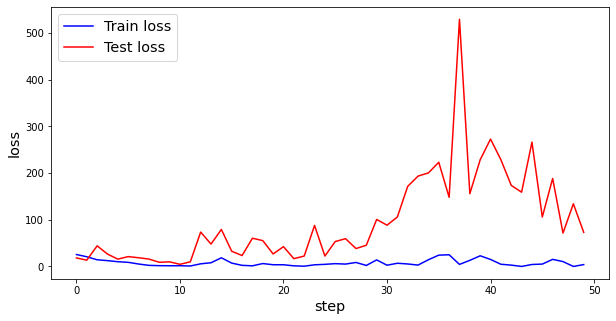

In [115]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
 
# plt.subplot(1, 2, 1)
train_steps = range(0,50)
 
plt.plot(train_steps, loss_train, color='blue', label="Train loss")
plt.plot(train_steps, loss_test, color='red', label="Test loss")

plt.ylabel("loss", fontsize='x-large')
plt.xlabel("step", fontsize='x-large')
plt.legend(loc='upper left', fontsize='x-large')


plt.show()



In [33]:
def agegap_effect(agegap,m,r):
    w = max(-1*m,min(agegap,m))/(2*m)
    e = w*r
    if e==0.5:
        return 100
    else:
        return (0.5+e)/(0.5-e)

In [92]:
def test_acc(dataset,m,r):
    total_acc = 0
    male_acc,female_acc=0,0
    male,female=0,0
    for data in dataset:
        output = model(data['image'].unsqueeze(0))
        prob = F.softmax(output, dim=1).squeeze(0).detach().numpy()

        e = agegap_effect(float(data['agegap'][1:-1]),m,r)
        if prob[1]==0:
            pred = 1
        else:
            p1 = prob[0]/prob[1]
            p2 = e*p1
            if p2>=1:
                pred = 0
            else:
                pred = 1
       
        total_correct = (pred == data['label']).sum()
        total_acc += total_correct.item() 
        if data['sex']==0:
            male+=1
            male_acc += total_correct.item() 
        else:
            female+=1
            female_acc += total_correct.item() 
    return total_acc/len(dataset),male_acc/male,female_acc/female


/var/folders/5c/bwvd_bwn5pbdf4lh0xfrjp0r0000gn/T/ipykernel_2965/319623282.py:10: RuntimeWarning: divide by zero encountered in float_scalars
  p1 = prob[0]/prob[1]
/var/folders/5c/bwvd_bwn5pbdf4lh0xfrjp0r0000gn/T/ipykernel_2965/319623282.py:10: RuntimeWarning: overflow encountered in float_scalars
  p1 = prob[0]/prob[1]
/var/folders/5c/bwvd_bwn5pbdf4lh0xfrjp0r0000gn/T/ipykernel_2965/319623282.py:11: RuntimeWarning: invalid value encountered in multiply
  p2 = e*p1


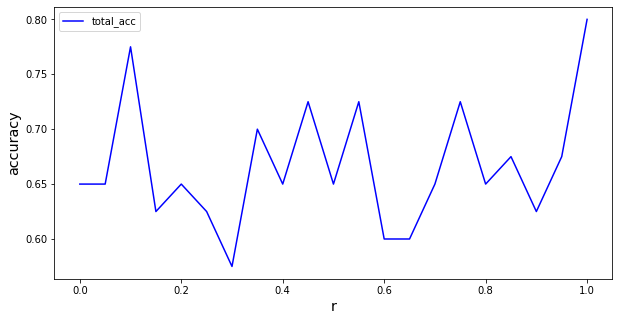

In [60]:
acc = []
male_,female_=[],[]
r_list = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
for i in r_list:
    total_acc,male_acc,female_acc = test_acc(testset,10,i)
    acc.append(total_acc)
    male_.append(male_acc)
    female_.append(female_acc)

plt.figure(figsize=(10, 5))
plt.plot(r_list, acc, color='blue', label="total_acc")

plt.ylabel("accuracy", fontsize='x-large')
plt.xlabel("r", fontsize='x-large')
plt.legend()

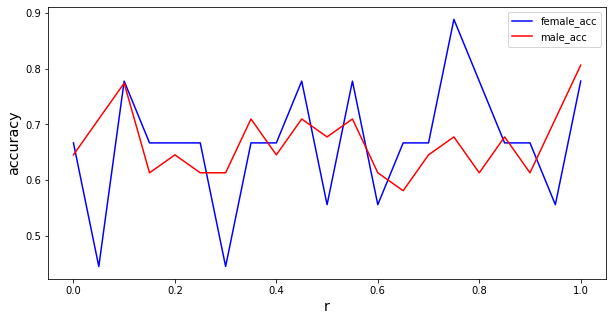

In [61]:
plt.figure(figsize=(10, 5))
plt.plot(r_list, female_, color='blue', label="female_acc")
plt.plot(r_list, male_, color='red', label="male_acc")

plt.ylabel("accuracy", fontsize='x-large')
plt.xlabel("r", fontsize='x-large')

plt.legend()

In [104]:
acc = []
male_,female_=[],[]

r_list = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
for i in r_list:
    total_acc,male_acc,female_acc = test_acc(dataset,10,i)
    acc.append(total_acc)
    male_.append(male_acc)
    female_.append(female_acc)



/var/folders/5c/bwvd_bwn5pbdf4lh0xfrjp0r0000gn/T/ipykernel_2965/3585530042.py:13: RuntimeWarning: overflow encountered in float_scalars
  p1 = prob[0]/prob[1]
/var/folders/5c/bwvd_bwn5pbdf4lh0xfrjp0r0000gn/T/ipykernel_2965/3585530042.py:13: RuntimeWarning: overflow encountered in float_scalars
  p1 = prob[0]/prob[1]
/var/folders/5c/bwvd_bwn5pbdf4lh0xfrjp0r0000gn/T/ipykernel_2965/3585530042.py:13: RuntimeWarning: overflow encountered in float_scalars
  p1 = prob[0]/prob[1]
/var/folders/5c/bwvd_bwn5pbdf4lh0xfrjp0r0000gn/T/ipykernel_2965/3585530042.py:13: RuntimeWarning: overflow encountered in float_scalars
  p1 = prob[0]/prob[1]
/var/folders/5c/bwvd_bwn5pbdf4lh0xfrjp0r0000gn/T/ipykernel_2965/3585530042.py:13: RuntimeWarning: overflow encountered in float_scalars
  p1 = prob[0]/prob[1]
/var/folders/5c/bwvd_bwn5pbdf4lh0xfrjp0r0000gn/T/ipykernel_2965/3585530042.py:13: RuntimeWarning: overflow encountered in float_scalars
  p1 = prob[0]/prob[1]
/var/folders/5c/bwvd_bwn5pbdf4lh0xfrjp0r0000gn

/var/folders/5c/bwvd_bwn5pbdf4lh0xfrjp0r0000gn/T/ipykernel_2965/3585530042.py:13: RuntimeWarning: overflow encountered in float_scalars
  p1 = prob[0]/prob[1]
/var/folders/5c/bwvd_bwn5pbdf4lh0xfrjp0r0000gn/T/ipykernel_2965/3585530042.py:13: RuntimeWarning: overflow encountered in float_scalars
  p1 = prob[0]/prob[1]
/var/folders/5c/bwvd_bwn5pbdf4lh0xfrjp0r0000gn/T/ipykernel_2965/3585530042.py:13: RuntimeWarning: overflow encountered in float_scalars
  p1 = prob[0]/prob[1]
/var/folders/5c/bwvd_bwn5pbdf4lh0xfrjp0r0000gn/T/ipykernel_2965/3585530042.py:13: RuntimeWarning: overflow encountered in float_scalars
  p1 = prob[0]/prob[1]
/var/folders/5c/bwvd_bwn5pbdf4lh0xfrjp0r0000gn/T/ipykernel_2965/3585530042.py:13: RuntimeWarning: overflow encountered in float_scalars
  p1 = prob[0]/prob[1]
/var/folders/5c/bwvd_bwn5pbdf4lh0xfrjp0r0000gn/T/ipykernel_2965/3585530042.py:13: RuntimeWarning: overflow encountered in float_scalars
  p1 = prob[0]/prob[1]
/var/folders/5c/bwvd_bwn5pbdf4lh0xfrjp0r0000gn

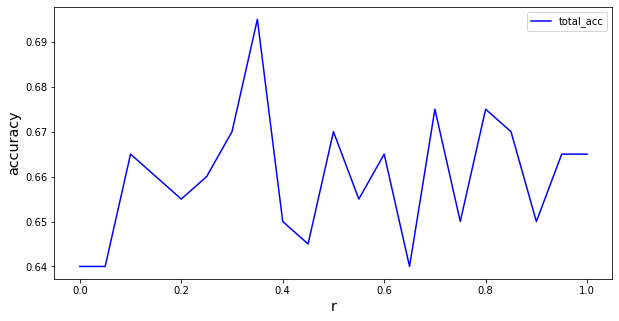

In [105]:
plt.figure(figsize=(10, 5))
plt.plot(r_list, acc, color='blue', label="total_acc")

plt.ylabel("accuracy", fontsize='x-large')
plt.xlabel("r", fontsize='x-large')
plt.legend()

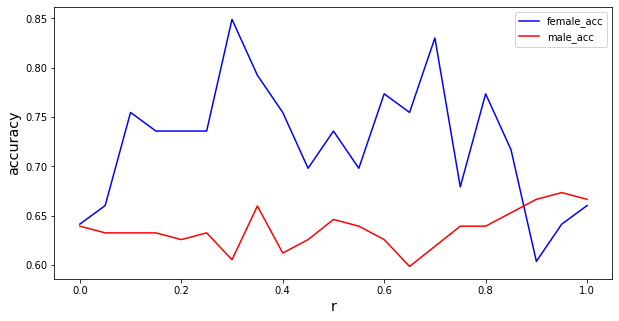

In [106]:
plt.figure(figsize=(10, 5))
plt.plot(r_list, female_, color='blue', label="female_acc")
plt.plot(r_list, male_, color='red', label="male_acc")

plt.ylabel("accuracy", fontsize='x-large')
plt.xlabel("r", fontsize='x-large')

plt.legend()

In [107]:
acc

[0.64,
 0.64,
 0.665,
 0.66,
 0.655,
 0.66,
 0.67,
 0.695,
 0.65,
 0.645,
 0.67,
 0.655,
 0.665,
 0.64,
 0.675,
 0.65,
 0.675,
 0.67,
 0.65,
 0.665,
 0.665]

In [108]:
female_

[0.6415094339622641,
 0.660377358490566,
 0.7547169811320755,
 0.7358490566037735,
 0.7358490566037735,
 0.7358490566037735,
 0.8490566037735849,
 0.7924528301886793,
 0.7547169811320755,
 0.6981132075471698,
 0.7358490566037735,
 0.6981132075471698,
 0.7735849056603774,
 0.7547169811320755,
 0.8301886792452831,
 0.6792452830188679,
 0.7735849056603774,
 0.7169811320754716,
 0.6037735849056604,
 0.6415094339622641,
 0.660377358490566]

In [109]:
male_

[0.6394557823129252,
 0.6326530612244898,
 0.6326530612244898,
 0.6326530612244898,
 0.6258503401360545,
 0.6326530612244898,
 0.6054421768707483,
 0.6598639455782312,
 0.6122448979591837,
 0.6258503401360545,
 0.6462585034013606,
 0.6394557823129252,
 0.6258503401360545,
 0.5986394557823129,
 0.6190476190476191,
 0.6394557823129252,
 0.6394557823129252,
 0.6530612244897959,
 0.6666666666666666,
 0.673469387755102,
 0.6666666666666666]